# Project 2 - Forecast correction

## General Overview

### Understand Assignment
https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service
- Given 2023 discrepancies between forecast and actual values, what will the temperatures be at the vlinder station in 2024?
    - Seem that temperaturs at vlinder station tend to be hotter than the forecast

- The ensemble mean of the corrected forecast is a linear function of the ensemble mean(s) of the predictor(s)
- mean and std dev of Forecast
- direct output from computer simulations of the atmosphere needs calibration before it can be meaningfully compared with observations of weather variables. This calibration process is often known as model output statistics (MOS). The simplest form of such calibration is to correct biases, using a bias correction calculated from past forecast errors

### Look at data/Clean
- [x] Add data from all the forecasts of 2023
    - We dont especially need to sort 
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - correlation analysis/feature importance ranking/Principal Component Analysis 
    - Do we keep tmp at vlinder in training data or do we use it only as a target?
    - Drop const values (or nearly const given threshhold)
    - At what level of correletion do i keep my values?
    - Simple regression on t2m sufficient?
- Sync data: vlinder:
    - [x] need same time frame than Forecast -> need a way to get it directly from the max and min of forecast csv
    - [x] merge because of time stamps (do i take the mean of tmp on elapsed period or precise timestamp ?)
- How to treat small vlinder data set?
- Rounding errors in ecmwf t2m data?
- RandomForest Regressor
- Nonhomogeneous Gaussian regression

### Nice things to have
- [ ] Use pipelines to automate operations
- [ ] Consumption of energy + log

### Misc
- Name of station ? ecmwf? station?
- All of the data visualization is happening on the whole set, no split atm probably not good

In [1]:
%pip install codecarbon

Note: you may need to restart the kernel to use updated packages.


In [2]:
from codecarbon import track_emissions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

# Match data sets
Need to resample data from the vlinder station to match the measurements of the forecast.
- We add all the different forecasts in one dataframe
    - Need to be carefull with duplicate data (does it matter to take the days of the same ensemble forecast?) 
- Resample on frequency, vlinder measures every 5 minutes where as the forecast is given for every 6 hours
- Resize on time frame, we need our ensemble forecast timestamps to match measurements at vlinder station
    - Need to match data of vlinder station

In [3]:
#from https://stackoverflow.com/questions/33503993/read-in-all-csv-files-from-a-directory-using-python
import glob

df_vlinder = pd.read_csv("vlinder19_03_2023.csv")
df_vlinder.rename(columns={"temp": "vlinder_temp"}, inplace=True)
df_vlinder.reset_index()


#Read all the csv files in forecast folder and add them to a dataframe
# time values are NOT monotonically increasing, as they are added depending on ordering in folder
df_fc = pd.DataFrame()
for file_name in glob.glob("forecast/"+'*.csv'):
    # open csv file to add
    to_add = pd.read_csv(file_name)
    if df_fc.empty: 
        df_fc = to_add
    # Take values only forecasts that are not yet present in dataframe
    df_diff = to_add[~to_add.time.isin(df_fc.time)]
    # Add difference to datatframe
    df_fc = pd.concat([df_fc,df_diff],axis=0)

# Sort date time to have monotonic increasing values
# Forecast numbers are not in order anymore -> need stable sort
df_fc.rename(columns={"time": "datetime"}, inplace=True)
df_fc['datetime'] = pd.to_datetime(df_fc['datetime'])
#Need merge sort to have a stable sort
df_fc = df_fc.sort_values(by='datetime', kind='mergesort')
assert df_fc['datetime'].is_monotonic_increasing, "Values in dataframe are not sorted"

#resampling vlinder data on 6 hours
df_vlinder['datetime'] = pd.to_datetime(df_vlinder['datetime'])
df_vlinder_res_first = df_vlinder.set_index('datetime').resample('6h').first().reset_index()
df_vlinder_res_mean = df_vlinder.set_index('datetime').resample('6h').mean().reset_index()

# Returns dataframe between values [start, end], format (%Y-%M-%D %h:%m:%s) for start and end
def resize_df_datetime(start, end, df):
    return df[(df['datetime'] >= start) & (df['datetime'] <= end)]    

#Keep data for dates that appear in both dataframes (vlinder and ensemble forecast)
start_df = max(df_vlinder['datetime'].min(), df_fc['datetime'].min())
end_df = min(df_vlinder['datetime'].max(), df_fc['datetime'].max())
df_fc = resize_df_datetime(start_df, end_df, df_fc)

fc_datetime = df_fc['datetime']
df_vlinder_res_first = df_vlinder_res_first[df_vlinder_res_first['datetime'].isin(fc_datetime)]
df_vlinder_res_mean = df_vlinder_res_mean[df_vlinder_res_mean['datetime'].isin(fc_datetime)]

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
   - We can also choose here which time period we consider
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

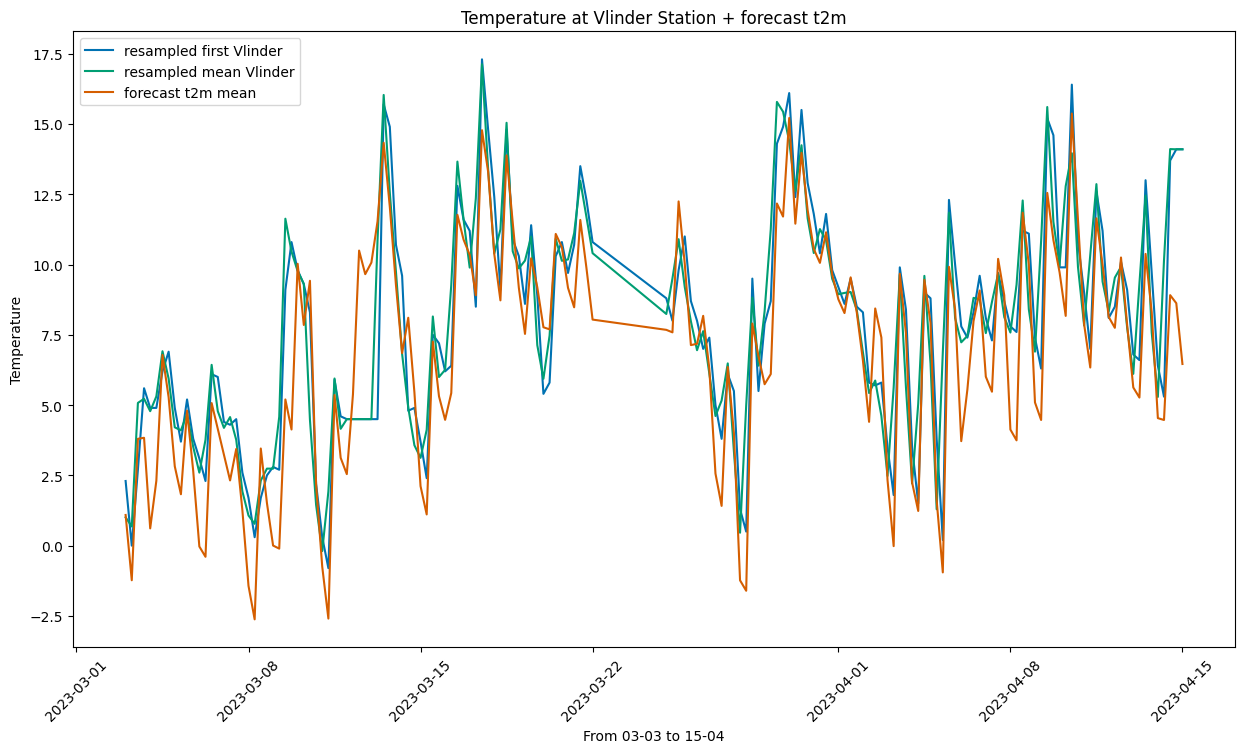

In [5]:
#get the mean value of a given datetime value on temperatures
#target column of forecast dataframe
target = 't2m'
ensmean_forecast = df_fc.groupby('datetime')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]

#Displays vlinder temperatures resampled on mean and first feature as well as an additional variable
def display_first_mean_additional(df_fc, additional):
    vlinder_res_first = resize_df_datetime(df_fc['datetime'].min(), df_fc['datetime'].max(), df_vlinder_res_first)
    vlinder_res_mean = resize_df_datetime(df_fc['datetime'].min(), df_fc['datetime'].max(), df_vlinder_res_mean)
    plt.figure(figsize=(15, 8))
    plt.plot(vlinder_res_first['datetime'], vlinder_res_first['vlinder_temp'], label='resampled first Vlinder')
    plt.plot(vlinder_res_mean['datetime'], vlinder_res_mean['vlinder_temp'], label='resampled mean Vlinder')
    plt.plot(additional['datetime'], additional[target], label=f'forecast {target} mean')
    plt.legend(loc='upper left')
    plt.xlabel(f"""From {start_df.strftime("%d-%m")} to {end_df.strftime("%d-%m")}""")
    plt.ylabel('Temperature')
    plt.title(f'Temperature at Vlinder Station + forecast {target}')
    plt.xticks(rotation=45)
    plt.show()

display_first_mean_additional(df_fc, ensmean_forecast)

TODO
We can see that around the 2023-04-15 there is a big difference between vlinder and ensemble forecast, there is probably an issue with measurement -> Might need to drop that !

In [ ]:
#df_fc = resize_df_datetime(df_fc['datetime'].min(), "2023-04-15 00:00:00", df_fc)
#display_first_mean_ensmean(df_fc)

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the tmp at the ecmwf station and temp at vlinder station (mean or first)


In [6]:
from functools import partial

# Select a starting point to compute correlation from
# format (%Y-%M-%D %h:%m:%s)
# "2023-04-01 00:00:00"
START_FC = df_fc['datetime'].min()
END_FC = df_fc['datetime'].max()

start = pd.Timestamp(START_FC)
end = pd.Timestamp(END_FC)

# Partial application of resize_df_datetime function
start_end_df = partial(resize_df_datetime, start, end)

# Filter resampled vlinder data based on time frame
df_v_first_filter = start_end_df(df_vlinder_res_first)
df_v_mean_filter = start_end_df(df_vlinder_res_mean)
df_ensmean_filter = start_end_df(ensmean_forecast)

#Compute Correlation between each resampling technique and the temperatur forecast at station, selected for a certain starting point
df_vlinder_resampled_temperature_metrics = [df_v_first_filter, df_v_mean_filter]

corr_values = list(map(lambda df : df['vlinder_temp'].corr(df_ensmean_filter[target]), df_vlinder_resampled_temperature_metrics))
# For some reason correlation is really low???
print(f"correlation: {corr_values}")

#Highest correlated resampled technique
best_resampled_metric_id = corr_values.index(max(corr_values))
assert best_resampled_metric_id == 0, "Selected resampling is NOT first()"

resample_to_merge = df_vlinder_resampled_temperature_metrics[best_resampled_metric_id]

correlation: [0.16562271143230176, 0.07767122064539017]


### 2 Extend Ensemble forecast with Vlinder temperatures

We selected the best resampling technique for the vlinder temperatures, we can now merge both dataframes together to create the final dataframe

In [ ]:
#Merge resampled vlinder temperatures into the data frame (use only first)
df_fc_merged = pd.merge(df_fc, resample_to_merge, on='datetime')
df_fc_merged = df_fc_merged[(df_fc_merged['datetime'] >= start) & (df_fc_merged['datetime'] <= end)]
df_fc_merged.to_csv('tmp.csv')

# Dependencies Analysis

As our data is now merged, I will analyze dependencies between our feature variables (from the ensemble forecast) and our target variables (observed vlinder temperature)

In [ ]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()

display_corr_matrix(df_fc_merged)

In [ ]:
correlations = df_fc_merged.corr()['vlinder_temp'].sort_values(ascending=False).drop('vlinder_temp')
correlations

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (t2m, d2m, mx2t6, mn2t6,..). However those variables are also heavily cross-correlated, which means that we might want to drop them later. 

Latitude and longitude are constant values that hold no explicative power, we will drop them later

We also need to check for NaN values.


In [ ]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(df_fc_merged)

We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 if they appear to be interesting

In [ ]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

# Drop all columns that have NaN values or that are constant.
df_fc_merged.dropna(axis=1, how='any', inplace=True)
df_fc_merged = remove_cst_values(df_fc_merged)
df_fc_merged

# Spliting train, validation and test data

When creating our different sets, if we randomly split our data we also separate a given ensemble forecast into our different sets.

We need a special function that rounds up the the 50th closest observation to keep ensemble forecasts together in each set. 
At the moment we select a given percentage and round up to the closest value that is a multiple of 50, that way we get only whole ensemble forecasts.
We also need to select only from a given date onwards, this means that our test set is at one end of our set.

In [ ]:
y = df_fc_merged['vlinder_temp']

#TODO might need to keep datetime for later use
#We need to drop datetime to call fit_tranform
X = df_fc_merged.drop(columns=['vlinder_temp', 'datetime'])

In [ ]:
from sklearn.model_selection import train_test_split

# Function used to round up to the 50th closest value to avoid splitting different samples
# Returns number of entries to select
def get_nb_entries(df, percent):
    return math.floor(df.shape[0] * percent / 50) * 50

# With shuffle=False we use only the end -> the entries at the end is split if we take a "random" percentage
# We need to round up to a percentage that keeps time stamp whole
# Split the training set into new training and validation sets (~ 80% training, ~20% test)
nb_test_entries = get_nb_entries(X, 0.8)
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, train_size=nb_test_entries, shuffle=False)

# Split the training set into new training and validation sets (~75% training, ~25% validation)
nb_validation_entries = get_nb_entries(X_train_tmp, 0.75)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, train_size=nb_validation_entries, shuffle=False)
X_train.to_csv('tmp.csv')

In [ ]:
#TODO, scale or not ?
#Need to scale the data 
#from sklearn.preprocessing import StandardScaler 

#scaler_x = StandardScaler().fit(X_train)
#X_scale = scaler_x.transform(X_train)

In [ ]:
# TODO: automate to select the best k
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

#TODO probably need to drop highly cross related values -> Multicolineraty (not really as they measure the same thing)
#At what treshhold should i throw out values?
# Do we use multiple factor regression?
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train.values, y_train.values)
cols_idxs = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]
print(features_df_new)

# Simple solution

"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We build a set with $tmp_{observed}$, $tmpfc_{1},\ \ldots, \ tmpfc_{50}$, data, ensemble mean and ensemble sdd

In [ ]:
# returns set that contains observed temperatures, forecast temperatures, ensemble mean and ensemble ssd 
def aggregate_transpose(df):
    df = df[['t2m', 'datetime']]
    # groups t2m entries in one datetime entry
    df_datetime = df.groupby('datetime').apply(lambda x: x.reset_index(drop=True))
    #creating one column entry per t2m value
    df_unstacked = df_datetime.unstack()
    #dropping datetime as group by has been done
    df_unstacked.drop(columns='datetime', inplace=True)
    return df_unstacked

df_simple_solution_transposed = aggregate_transpose(df_fc_merged)

#Insert vlinder temperatures into transposed dataframe, match data on datetime
df_vlinder_datetime_index = df_vlinder_res_first.set_index('datetime')
assert df_vlinder_datetime_index.index.equals(df_simple_solution_transposed.index), f"Indices (=> datetime) of transposed df and resampled vlinder should match\n GOT {df_vlinder_datetime_index.index}\n EXPECTED {df_simple_solution_transposed.index}"

df_simple_solution_transposed['ensmean'] = df_simple_solution_transposed.mean(axis=1)
df_simple_solution_transposed['enssd'] = df_simple_solution_transposed.std(axis=1)
df_simple_solution_transposed['temp_vlinder'] = df_vlinder_datetime_index[:]

#df_simple_solution = pd.concat([df_vlinder_datetime_index, df_simple_solution_transposed], axis=1)
#df_simple_solution.rename(columns={'temp': 'temp_vlinder', inplace=True)
df_simple_solution_transposed['temp_vlinder'] = df_simple_solution_transposed['temp_vlinder'] + C_0
df_simple_solution = df_simple_solution_transposed

In [ ]:
x = np.linspace(min(df_simple_solution['ensmean'] - C_0), max(df_simple_solution['ensmean'] - C_0))
y = x

plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can see that we have a negative bias in our ensemble forecast as most of our data points are above the x = y line

In [ ]:
X = df_simple_solution['ensmean'].values.reshape(-1, 1)
y = df_simple_solution['temp_vlinder'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from codecarbon import EmissionsTracker

def train_model(model, X_train, y_train, tracker):
    tracker.start()
    try:
        model.fit(X_train, y_train)
    finally:
        tracker.stop()
    return model

@track_emissions()
def train_model_2(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

tracker = EmissionsTracker()

#model = train_model(LinearRegression(), X_train, y_train, tracker)
model = train_model_2(LinearRegression(), X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficients:", model.coef_)

# Print the mean squared error
print("Mean squared error:", mean_squared_error(y_test, y_pred))

# Print the coefficient of determination (R^2 score)
print("Coefficient of determination (R^2 score):", r2_score(y_test, y_pred))

When selecting only one week our result are less precise as above
**!!! Conclusion drawn from test set as both have not been conducted in parrallel**

We need to take only one week with LOOCV and compare it to the whole data set with LOOCV

Linear Regression if only one week is selected
- Coefficients: [[0.76954526]]
- Mean squared error: 3.2674047991823643
- Coefficient of determination (R^2 score): 0.691794647528979


In [ ]:
plt.scatter(df_simple_solution['ensmean'] - C_0, df_simple_solution['temp_vlinder'] - C_0, marker='o')
plt.plot(X_test - C_0, y_pred - C_0, color='red', label='regression')
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

# Correcting forecast

In [ ]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_16_03_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")
to_correct = to_correct[['time', 'number', 't2m']]

to_correct.rename(columns={'time': 'datetime'}, inplace=True)
transposed = aggregate_transpose(to_correct)
transposed.reset_index(inplace=True)
transposed_datetime = transposed['datetime']
transposed.drop(columns='datetime', inplace=True)

df_corrected_t2m = transposed.copy()
for index, row in df_corrected_t2m.iterrows(): 
    y_row = model.predict(row.values.reshape(-1, 1))
    #squeeze to reshap np array into one dimension
    df_corrected_t2m.iloc[index] = np.squeeze(y_row)

df_corrected_t2m['datetime'] = transposed_datetime
df_corrected_t2m.set_index('datetime', inplace=True)


In [ ]:
print(to_correct[['datetime', 't2m']])

# reshapes corrected temperatures values to have same format as to_correct
df_reshaped = df_corrected_t2m.T.melt(var_name='datetime', value_name='t2m')

to_correct['t2m'] = df_reshaped['t2m']

df_corrected = to_correct

df_corrected.rename(columns={"datetime": "time"}, inplace=True)


df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

# Tests of CodeCarbon
Synthetic neural network, used to check power consumption using CodeCarbon packet

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Multi-layer Perceptron Classifier
clf = MLPClassifier(hidden_layer_sizes=(100, 5), activation='relu', solver='adam', max_iter=500, random_state=42)

train_model_2(clf, X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)